### packages

In [9]:
import numpy as np

import pandas as pd

import pulp

import networkx as nx

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from scipy.optimize import minimize

### parameters

\begin{align}
\begin{split}
&f_{o,d,2}=\theta_{0}+ \theta_{1}\cdot \textrm{ETD}_{o} + \theta_{2}\cdot \textrm{ETT}_{o}
\label{eq: linear fare}
\end{split}
\end{align}

\begin{align}
\begin{split}
&w_{o,d,2}=\lambda f_{o,d,2}
\label{eq: linear wage}
\end{split}
\end{align}

In [10]:
################################################################################################

order_num=10

driver_num=10

################################################################################################

theta_0=2.55

theta_1=0.35

theta_2=1.08

lambda_=0.75

################################################################################################

alpha0=0

alpha1=3.2

alpha2=0.6

################################################################################################

beta0=0.0

beta1=2.0

beta2=0.5

### generate data

\begin{equation}
u_{o,d,i} = \overbrace{\alpha_{0,o}}^{\textrm{constant term}} - \overbrace{\alpha_{1,o} \cdot f_{o,d,i}}^{\textrm{order fare}} - \overbrace{ \alpha_{2,o} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall o \in O,
\label{eq:order utility}
\end{equation}

\begin{equation}
v_{o,d,i} = \overbrace{\beta_{0,d}}^{\textrm{constant term}} + \overbrace{\beta_{1,d} \cdot w_{o,d,i}}^{\textrm{wage}} - \overbrace{ \beta_{2,d} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall d \in D
\label{eq:driver utility}
\end{equation}

\begin{align}
    \begin{split}
    &\max_{x_{o,d,2}} \mathbb{Q}= \sum_{o\in O} \sum_{d\in D}  (f_{o,d,2}-w_{o,d,2})  \cdot x_{o,d,2}
    \label{eq:objective of platform 2}
    \end{split}\\
    \begin{split}
    \text{subject to}&\sum_{d \in D} x_{o,d,2} \leq  1, \forall o \in O
    \label{eq:constrain 1 of platform 2}
    \end{split}\\
    \begin{split}
    &\sum_{o \in O} x_{o,d,2} \leq 1, \forall d \in D
    \label{eq:constrain 2 of platform 2}
    \end{split}
    \end{align}

In [11]:
ETD=np.random.uniform(3,10,order_num)

ETT=np.random.uniform(3,10,order_num)

################################################################################################

Fare2=theta_0*np.ones(order_num)+theta_1*ETD+theta_2*ETT

Fare2=np.tile(np.array([Fare2]).transpose(), (1,driver_num))

################################################################################################

Wage2=lambda_*Fare2

################################################################################################

Tau=np.random.uniform(3,10,[order_num,driver_num])

################################################################################################

U2=alpha0*np.ones([order_num,driver_num])-alpha1*Fare2-alpha2*Tau

################################################################################################

V2=beta0*np.ones([order_num,driver_num])+beta1*Wage2-beta2*Tau

################################################################################################

u_decline=U2.mean()

v_decline=V2.mean()

print('Deline utility of passenger is ',u_decline)

print('Deline utility of driver is ',v_decline)


Deline utility of passenger is  -41.64367907097462
Deline utility of driver is  14.609857428937142


### Ride-matching of platform 2

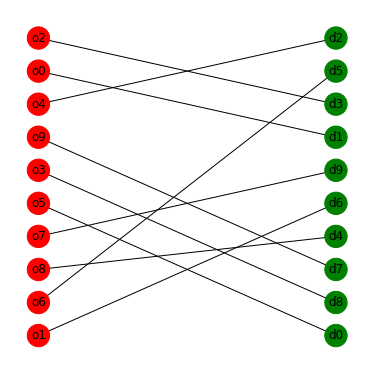

In [12]:
def Bipartite_matching(Weights):
    
    # model

    model = pulp.LpProblem("Ride_Matching_Problems", pulp.LpMaximize)

    # variables

    X = pulp.LpVariable.dicts("X",((O,D) for O in range(Weights.shape[0]) for D in range(Weights.shape[1])),lowBound=0,upBound=1,cat='Integer')

    # objective

    model += (pulp.lpSum([Weights[O,D] * X[(O, D)] for O in range(Weights.shape[0]) for D in range(Weights.shape[1])]))

    # constraints

    for O in range(Weights.shape[0]):

        model += pulp.lpSum([X[(O, D)] for D in range(Weights.shape[1])]) <= 1

    for D in range(Weights.shape[1]):

        model += pulp.lpSum([X[(O, D)] for O in range(Weights.shape[0])]) <= 1
            
    # solvable

    model.solve()
    
    x = np.zeros([Weights.shape[0],Weights.shape[1]])
    
    for var in X:

        var_value = X[var].varValue

        if var_value !=0:

            x [var[0]][var[1]]=1
            
    return x

################################################################################################

Weights2=Fare2-Wage2

X2=Bipartite_matching(Weights2)

################################################################################################

G = nx.Graph()

order_nodes=['o'+str(o) for o in range(order_num)]

driver_nodes=['d'+str(d) for d in range(order_num)]

G.add_nodes_from(order_nodes, bipartite=0, label='passenger')

G.add_nodes_from(driver_nodes, bipartite=1, label='driver')

for o in range(order_num):

    for d in range(driver_num):
        
        if X2[o][d]==1:

            G.add_edge('o'+str(o),'d'+str(d))

################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G.nodes()]  

pos = nx.bipartite_layout(G, order_nodes)

plt.figure(figsize=(5,5)) 

nx.draw(G,pos,node_color=color_map,with_labels = True,node_size=500)

plt.show()
   
        

### Observable static competition

Fare and wage optimization, determines the optimal fare and wage for an arbitrary order-driver pair $(o,d)$, which maximizes the expected profit of such pair,

\begin{align}
\begin{split}
\max_{f_{o,d,1},w_{o,d,1}} \mathcal{P}(f_{o,d,1},w_{o,d,1}),\forall o \in O, \forall d \in D
\label{eq: pricing and waging objective}
\end{split}\\
\begin{split}
\text{subject to }&f_{o,d,1} \geq 0, \forall o \in O, \forall d \in D
\label{eq: pricing fare range}
\end{split}\\
\begin{split}
&w_{o,d,1} \geq 0, \forall o \in O, \forall d \in D.
\label{eq: pricing wage range}
\end{split}
\end{align}

\begin{equation}
\begin{aligned}
\mathcal{P}(f_{o,d,1},w_{o,d,1}|f_{o,d,2},w_{o,d,2},x_{o,d,2})=&   \frac{\textrm{exp}(u_{o,d,1})}{\textrm{exp}(u_{o}^{\textrm{c}})+\sum_{d \in D} \textrm{exp}(u_{o,d,2})\cdot x_{o,d,2}+\textrm{exp}(u_{o,d,1})}\\
& \cdot \frac{\textrm{exp}(v_{o,d,1})}{\textrm{exp}(v_{d}^{\textrm{c}})+\sum_{o \in O} \textrm{exp}(v_{o,d,2})\cdot x_{o,d,2}+ \textrm{exp}(v_{o,d,1})}  \cdot (f_{o,d,1}-w_{o,d,1}).
\label{eq: OS FW objective}
\end{aligned}
\end{equation}

Matching optimization, can be formulated as a maximum-weighted bipartite matching problem. A bipartite graph is first constructed to represent all the potential matches between passengers and drivers. A weighted edge connects each pair of the passenger and driver nodes, and the weight is the optimal expected profit $\mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})$ of order-driver pair $(o,d)$, $\forall o \in O$, $\forall d \in D$, derived from Fare and wage optimization,

\begin{align}
\begin{split}
&\max_{x_{o,d,1}} \mathbb{P} = \sum_{o\in O}\sum_{d\in D}  \mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})  \cdot x_{o,d,1}
\label{eq: matching objective}
\end{split}\\
\begin{split}
\text{subject to}&\sum_{d \in D} x_{o,d,1} \leq  1, \forall o \in O
\label{eq: matching constrain 1}
\end{split}\\
\begin{split}
&\sum_{o \in O} x_{o,d,1} \leq 1, \forall d \in D
\label{eq: matching constrain 2}
\end{split}\\
\begin{split}
&x_{o,d,1} \in \{0,1\}, \forall o \in O, \forall d \in D.
\label{eq: matching matching range}
\end{split}
\end{align}

In [15]:
class OS_optimization(object):
    
    ################################################################################################
    
    def __init__(self,Fare2,Wage2,X2,U2,V2,u_decline,v_decline,Tau):
        
        ################################################################################################
        
        self.Fare2=Fare2 # fare of platform 2
        
        self.Wage2=Wage2 # wage of platform 2
        
        self.X2=X2 # matching solution of platform 2
        
        ################################################################################################
        
        self.U2=U2 # passenger utility of platform 2
        
        self.V2=V2 # driver utility of platform 2
        
        ################################################################################################
        
        self.u_decline=u_decline
        
        self.v_decline=v_decline
        
        ################################################################################################
        
        self.Tau=Tau # pickup time of platform 2
        
    ################################################################################################
        
    def profit(self,X,o,d):
        
        ################################################################################################
        
        u1=alpha0-alpha1*X[0]-alpha2*self.Tau[o,d]
        
        v1=beta0+beta1*X[1]-beta2*self.Tau[o,d]
        
        ################################################################################################
        
        u2=self.U2[o,d]
        
        v2=self.V2[o,d]
        
        ################################################################################################
        
        u0=self.u_decline
        
        v0=self.v_decline
        
        ################################################################################################
        
        p=np.exp(u1)/(np.exp(u0)+np.exp(u2)*self.X2[o,d]+np.exp(u1))
    
        q=np.exp(v1)/(np.exp(v0)+np.exp(v2)*self.X2[o,d]+np.exp(v1))
        
        ################################################################################################
        
        return -1*p*q*(X[0]-X[1])
    
    ################################################################################################
    
    def weights(self,Fare1,Wage1):
        
        ################################################################################################
        
        Weights=np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                X=[Fare1[o,d],Wage1[o,d]]
                
                Weights[o,d]=-1*self.profit(X,o,d)
                
        return Weights
                
    ################################################################################################
    
    def solve(self):
        
        ################################################################################################
        
        order_num,driver_num=self.X2.shape[0],self.X2.shape[1]
        
        ################################################################################################
        
        Fare1,Wage1,X1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        U1,V1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                fw_opt = minimize(self.profit,[0,0],args=(o,d),method="trust-constr",bounds=((0, None), (0, None)))
                
                Fare1[o,d]=fw_opt.x[0]
                
                Wage1[o,d]=fw_opt.x[1]
                
                print(o,d)

        ################################################################################################
        
        Weights=self.weights(Fare1,Wage1)
        
        X1=Bipartite_matching(Weights)
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                U1[o,d]=alpha0-alpha1*Fare1[o,d]-alpha2*self.Tau[o,d]
                
                V1[o,d]=beta0+beta1*Wage1[o,d]-beta2*self.Tau[o,d]

        return Fare1,Wage1,X1,U1,V1


### user example

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


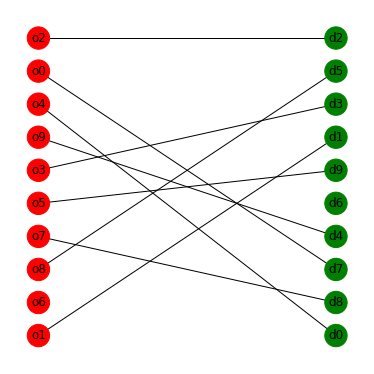

In [17]:
################################################################################################

optimization=OS_optimization(Fare2,Wage2,X2,U2,V2,u_decline,v_decline,Tau)

Fare1,Wage1,X1,U1,V1=optimization.solve()

################################################################################################

G = nx.Graph()

order_nodes=['o'+str(o) for o in range(order_num)]

driver_nodes=['d'+str(d) for d in range(order_num)]

G.add_nodes_from(order_nodes, bipartite=0, label='passenger')

G.add_nodes_from(driver_nodes, bipartite=1, label='driver')

for o in range(order_num):

    for d in range(driver_num):
        
        if X1[o][d]==1:

            G.add_edge('o'+str(o),'d'+str(d))

################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G.nodes()]  

pos = nx.bipartite_layout(G, order_nodes)

plt.figure(figsize=(5,5)) 

nx.draw(G,pos,node_color=color_map,with_labels = True,node_size=500)

plt.show()

### simulate the choice behaviour

In [64]:
def Choice(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2,u_decline,v_decline):
    
    ################################################################################################
        
    order_num,driver_num=X2.shape[0],X2.shape[1]
    
    ################################################################################################
    
    order_selection={}
    
    driver_selection={}
    
    ################################################################################################
    
    for o  in range(order_num):
        
        ################################################################################################
        
        choice_set={'decline':u_decline}
        
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[o,:])[0],np.nonzero(X2[o,:])[0]
        
        if len(matching1)>0:
        
            d1=matching1[0]
            
            choice_set['1']=U1[o,d1]
            
        if len(matching2)>0:
            
            d2=matching2[0]
            
            choice_set['2']=U2[o,d2]
            
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        order_selection[o]=selection
        
    ################################################################################################
    
    for d  in range(driver_num):
        
        ################################################################################################
        
        choice_set={'decline':v_decline}
        
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[:,d])[0],np.nonzero(X2[:,d])[0]
        
        if len(matching1)>0:
        
            o1=matching1[0]
            
            choice_set['1']=V1[o1,d]
            
        if len(matching2)>0:
            
            o2=matching2[0]
            
            choice_set['2']=V2[o2,d]
            
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        driver_selection[d]=selection
        
    ################################################################################################
        
    print(order_selection)
        
    print(driver_selection)
        
    ################################################################################################
    
    profit={'1':0,'2':0}
    
    for o,order_select in order_selection.items():
        
        order_platform,d=order_select.split('_')[0],int(order_select.split('_')[1])
        
        if order_platform!="decline":
            
            driver_select=driver_selection[d]
            
            driver_platform=driver_select.split('_')[0]
            
            if driver_platform==order_platform:
                
                if driver_platform=='1':
                    
                    profit[driver_platform]+=Fare1[o,d]-Wage1[o,d]
                    
                elif driver_platform=='2':
                    
                    profit[driver_platform]+=Fare2[o,d]-Wage2[o,d]
                    
    return profit

Choice(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2,u_decline,v_decline)
        

{0: '1_7', 1: '1_1', 2: '1_2', 3: '1_3', 4: '1_0', 5: '1_9', 6: '2_5', 7: '1_8', 8: '1_5', 9: '1_4'}
{0: 'decline_null', 1: '2_0', 2: '2_4', 3: 'decline_null', 4: '2_8', 5: 'decline_null', 6: 'decline_null', 7: 'decline_null', 8: 'decline_null', 9: '2_7'}


{'1': 0, '2': 0}